# Plotting of results from pretrained networks


In [3]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from master_models.pretrained import pretrained_model
%load_ext autoreload
%autoreload 2


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

## Data import

In [4]:

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_noscale_200k.npy")
    energies = load_feature_representation("energies_noscale_200k.npy")
    positions = load_feature_representation("positions_noscale_200k.npy")
    labels = load_feature_representation("labels_noscale_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))


Number of classes: 2
Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)


In [5]:
# Normalize image data and reshape to format that works with models
images = normalize_image_data(images)
images = np.concatenate((images, images, images), axis=3)

# Load model
Loads the defined pretrained model and predicts on a randomized test set

In [6]:
MODEL_PATH = "../../data/output/models/"
FIGURE_PATH = "../../reports/pretrained/figures/"
name = "DenseNet201-0.92.hdf5"

loaded_model = tf.keras.models.load_model(MODEL_PATH+name)

# Load feature representation
net = "DenseNet201"
depth = "full"
epochs = 5
# Load features
features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + "_new_"+".npy"
pretrained_features = load_feature_representation(features_filename)

# Indices to use for training and test
x_idx = np.arange(pretrained_features.shape[0])

# Split the indices into training and test sets
train_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.2)    

test_positions = positions[test_idx]
train_positions = positions[train_idx]
test_energies = energies[test_idx]
train_energies = energies[train_idx]
x_train = pretrained_features[train_idx]
x_test = pretrained_features[test_idx]
y_test = labels[test_idx]
y_train = labels[train_idx]


y_true = y_test.argmax(axis=-1)
tmp_predicted = loaded_model.predict(x_test)
y_pred = tmp_predicted.argmax(axis=-1)

# indices, relative distances and relative energies for test set
single_indices, double_indices, close_indices = event_indices(test_positions)
rel_distance_test = relative_distance(test_positions)
energy_diff_test = energy_difference(test_energies)
rel_energy_test = relative_energy(test_energies)


W1030 12:10:44.564635 139889545393984 deprecation.py:323] From /home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Some numbers from results
Mean separation distances, mean relative energies, events with separation < 3mm etc.

In [7]:
# Separate correct and wrong classifications
correct_doubles = np.where(y_pred[double_indices] == 1)[0]
wrong_doubles = np.where(y_pred[double_indices] == 0)[0]
correct_close_doubles = np.where(y_pred[close_indices] == 1)[0]

# Mean distances
mean_dist_correct = np.mean(rel_distance_test[double_indices][correct_doubles])
mean_dist_wrong = np.mean(rel_distance_test[double_indices][wrong_doubles])
mean_dist_all = np.mean(rel_distance_test[double_indices])

# Mean energies
mean_energy_all = np.mean(rel_energy_test[double_indices])
mean_energy_correct = np.mean(rel_energy_test[double_indices][correct_doubles])
mean_energy_wrong = np.mean(rel_energy_test[double_indices][wrong_doubles])


# Ratios
ratio_doubles = len(correct_doubles) / len(double_indices)
ratio_close = len(correct_close_doubles) / len(close_indices)


# Output
print("Number of events:")
print("Single: {} \nDouble: {} \nClose: {}\n".format(
    len(single_indices),
    len(double_indices),
    len(close_indices))
     )
print("Mean separations for classified double events:")
print("All doubles: {:.2f}mm \nCorrect: {:.2f}mm \nWrong: {:.2f}mm\n".format(
    mean_dist_all,
    mean_dist_correct,
    mean_dist_wrong)
     )

print("Mean relative energy for classified double events:")
print("All doubles: {:.2f}mm \nCorrect: {:.2f}mm \nWrong: {:.2f}mm\n".format(
    mean_energy_all,
    mean_energy_correct,
    mean_energy_wrong)
     )
print("Ratios of correctly classified double events:")
print("All doubles: {:.3f} \nClose: {:.3f}\n".format(
    ratio_doubles,
    ratio_close)
     )

print("Ratio of correct singles: %.3f" % (19749/len(single_indices)))

Number of events:
Single: 20013 
Double: 19987 
Close: 755

Mean separations for classified double events:
All doubles: 13.24mm 
Correct: 13.90mm 
Wrong: 9.59mm

Mean relative energy for classified double events:
All doubles: 0.50mm 
Correct: 0.55mm 
Wrong: 0.21mm

Ratios of correctly classified double events:
All doubles: 0.848 
Close: 0.432

Ratio of correct singles: 0.987


# Results on test set

## Confusion Matrix
The confusion matrix can be a useful metric to gain a little bit
more insight into specifically what the model gets wrong.
* Top left: Single events classified as single events
* Top right: Single events classified as double events
* Bottom left: Double events classified as single events
* Bottom right: Double events classified as double events

Confusion matrix, without normalization
[[19615   350]
 [ 3016 17019]]


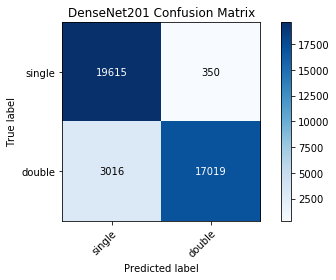

In [6]:
from analysis_functions.plotting import plot_confusion_matrix
classes = ["single", "double"]
title = net +" Confusion Matrix"
plot_confusion_matrix(y_true, y_pred, classes, title=title)
plt.show()
#plt.savefig(FIGURE_PATH+net+"_confmat.pdf", format="pdf")

## F1 Score

In [7]:
from sklearn.metrics import f1_score
score = f1_score(y_true, y_pred)
print("F1-score: ", score)

F1-score:  0.9100096246390761


### ROC curves
#### All events

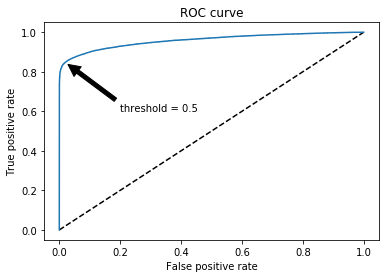

Area under curve: 0.9586188887664804


In [13]:
from analysis_functions.plotting import plot_roc_curve
from sklearn.metrics import roc_auc_score

plot_roc_curve(y_true, tmp_predicted[:,1])
plt.show()


print("Area under curve:",roc_auc_score(y_true, tmp_predicted[:,1]))

#### Close events

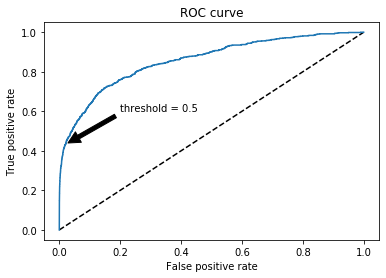

Area under curve: 0.8571308450831463


In [14]:
single_close_true = np.concatenate((y_true[single_indices], y_true[close_indices]), axis=0)
single_close_pred = np.concatenate((tmp_predicted[single_indices,1], tmp_predicted[close_indices,1]), axis=0)
plot_roc_curve(single_close_true, single_close_pred)
plt.show()


print("Area under curve:",roc_auc_score(single_close_true, single_close_pred))

# Distributions and scatterplot

## Test set

### Comparing correct and misclassified double events

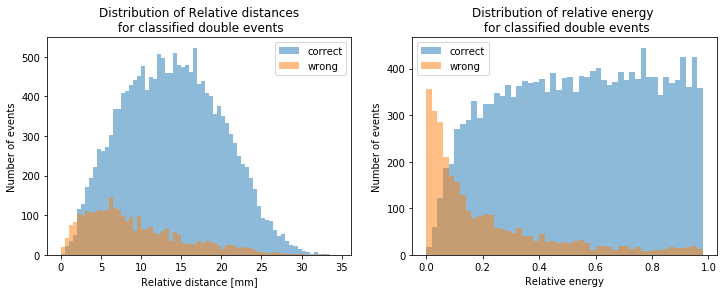

In [232]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(energy_diff_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of Relative distances\n for classified double events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

### Scatterplot relative distance vs. relative energy

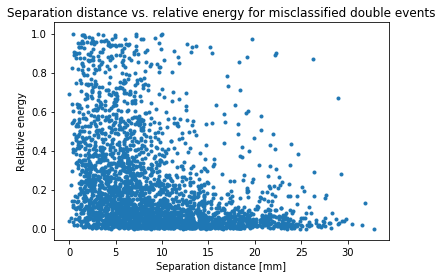

In [233]:
plt.scatter(
    rel_distance_test[double_indices][wrong_doubles], 
    rel_energy_test[double_indices][wrong_doubles],
    marker='.',
    )
plt.title("Separation distance vs. relative energy for misclassified double events")
plt.xlabel("Separation distance [mm]")
plt.ylabel("Relative energy")
plt.show()

## Events with high separation distance
and varying relative energy above a threshold

In [234]:
# Grab the indices
separation_lim = 25.0
energy_lim = 0.2
high_relD = np.where(rel_distance_test[double_indices][wrong_doubles] > separation_lim)[0]
high_relE = np.where(rel_energy_test[double_indices][wrong_doubles] > energy_lim)[0]

# Then get the overlapping indices
high_both = np.array(list(set(high_relD).intersection(set(high_relE))))
print("Found {} events.".format(len(high_both)))



Found 5 events.


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


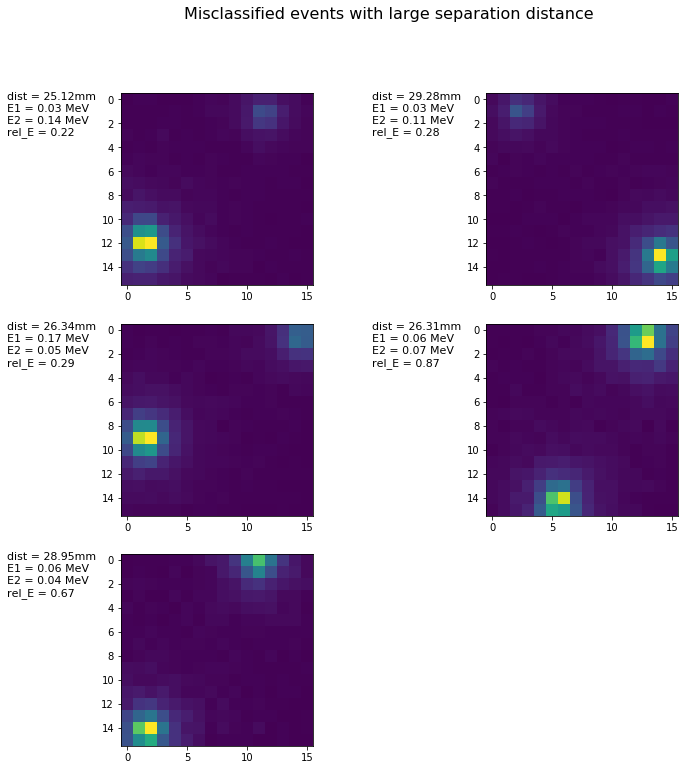

In [246]:
# Use the indices to fetch the images and other statistics we want.
images_plot_high = images[test_idx][double_indices][wrong_doubles][high_both][:,:,:,0]
rel_pos_plot_high = rel_distance_test[double_indices][wrong_doubles][high_both]
rel_energy_plot_high = rel_energy_test[double_indices][wrong_doubles][high_both]
energy_plot_high = energies[test_idx][double_indices][wrong_doubles][high_both]

# Plot the events images with relative separation, energies, and relative energy
# to the top left of each image
fig, ax = plt.subplots(3, 2, figsize=(12,12))
for i in range(3):
    for j in range(2):
        if i*2+j >= len(high_both):
            fig.delaxes(ax.flatten()[i*2 + j])
            continue
        ax[i, j].imshow(images_plot_high[i*2 + j])
        rel_pos = rel_pos_plot_high[i*2 + j]
        rel_E = rel_energy_plot_high[i*2 + j]
        E1 = energy_plot_high[i*2 + j, 0]
        E2 = energy_plot_high[i*2 + j, 1]
        relp = "dist = {:.2f}mm".format(rel_pos[0])
        rele = "rel_E = {:.2f}".format(rel_E[0])
        e1_txt = "E1 = {:.2f} MeV".format(E1)
        e2_txt = "E2 = {:.2f} MeV".format(E2)
        ax[i, j].text(-10, 0, relp, fontsize=11)
        ax[i, j].text(-10, 1, e1_txt, fontsize=11)
        ax[i, j].text(-10, 2, e2_txt, fontsize=11)
        ax[i, j].text(-10, 3, rele, fontsize=11)
        
fig.suptitle("Misclassified events with large separation distance", fontsize=16)
#fig.savefig(FIGURE_PATH+net+"_misclassified_large_dist.pdf", format="pdf")
fig.show()

# Plots of events that no networks were able to classify correctly

In [237]:
# Load indices
OUTPUT_PATH = MODEL_PATH = "../../data/output/"
fname_indices = "never_correct_indices_rerun.txt"
never_correct = np.loadtxt(OUTPUT_PATH + fname_indices, dtype=int).tolist()

rel_distance_all = relative_distance(positions)
rel_energy_all = relative_energy(energies)



## Distributions for relative distance and relative energy

W1002 18:41:38.050824 139808083375936 legend.py:1282] No handles with labels found to put in legend.
W1002 18:41:38.082546 139808083375936 legend.py:1282] No handles with labels found to put in legend.
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


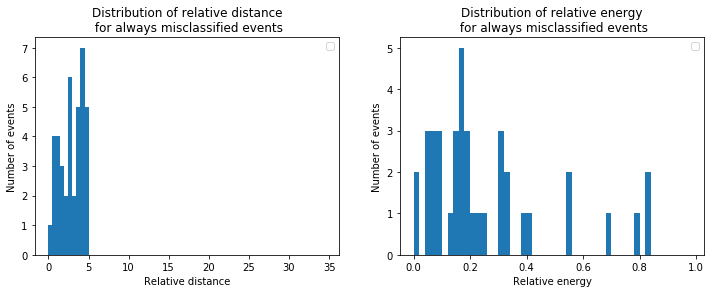

In [238]:
# Calculate bins
dist_bins = np.arange(0, np.amax(rel_distance_all), 0.5)
energy_bins = np.arange(0, np.amax(rel_energy_all), 0.02)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_all[never_correct], bins=dist_bins)
ax[0].set_title("Distribution of relative distance\n for always misclassified events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()

ax[1].hist(rel_energy_all[never_correct], bins=energy_bins)
ax[1].set_title("Distribution of relative energy\n for always misclassified events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()

#fig.savefig(FIGURE_PATH+net+"_relative_noncorrect.pdf", format="pdf")
fig.show()

## Plot images of some of the events

Number of always misclassified events: 39


/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


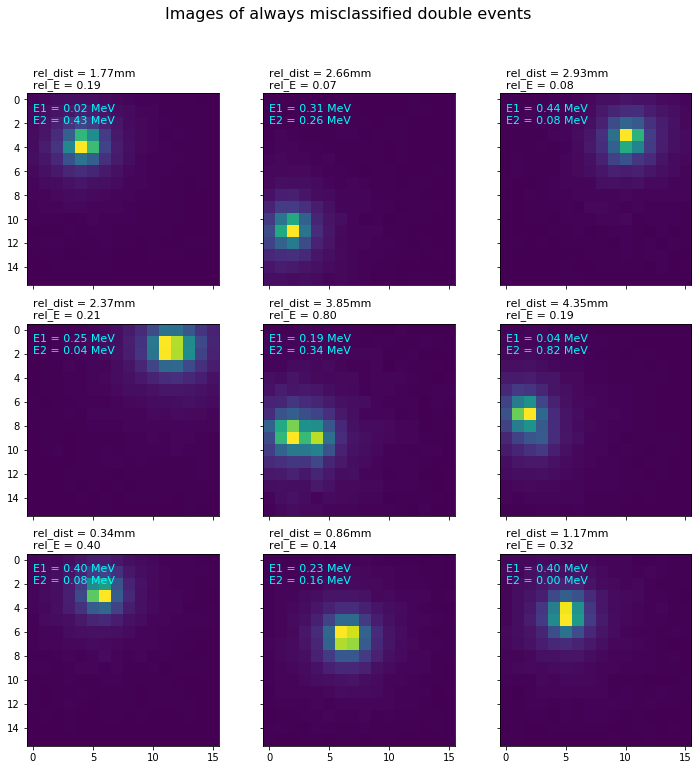

In [254]:
print("Number of always misclassified events:", len(never_correct))

images_plot = images[never_correct][:,:,:,0]
rel_dist_plot = rel_distance_all[never_correct]
rel_energy_plot = rel_energy_all[never_correct]
energy_plot = energies[never_correct]
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
index = 10
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(images_plot[index + i*3 + j])
        rel_dist = rel_dist_plot[index + i*3 + j]
        rel_energy = rel_energy_plot[index + i*3 + j]
        E1 = energy_plot[i*3 + j, 0]
        E2 = energy_plot[i*3 + j, 1]
        rel_d = "rel_dist = {:.2f}mm".format(rel_dist[0])
        rel_e = "rel_E = {:.2f}".format(rel_energy[0])

        e1_txt = "E1 = {:.2f} MeV".format(E1)
        e2_txt = "E2 = {:.2f} MeV".format(E2)
        ax[i, j].text(0,-2, rel_d, color='black', fontsize=11)
        ax[i, j].text(0,-1, rel_e, color='black', fontsize=11)
        ax[i, j].text(0,1, e1_txt, color='cyan', fontsize=11)
        ax[i, j].text(0,2, e2_txt, color='cyan', fontsize=11)


fig.suptitle("Images of always misclassified double events", fontsize=16)
#fig.savefig(FIGURE_PATH+net+"_nocorrect_samples.pdf", format="pdf")

fig.show()
        

        

In [ ]:
# Plot some images, with electron origin positions
%matplotlib inline

images = images.reshape(images.shape[0],16,16)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
for i in range(3):
    for j in range(3):
        # plot image
        ax[i, j].imshow(images[index + i*3 + j])
        
        # plot origin of event
        x = positions[index + i*3 + j, 0]
        y = positions[index + i*3 + j, 1]
        ax[i, j].plot(x, y, 'rx')
        ax[i, j].set_title('single')
        if positions[index + i*3 + j, 3] != -100:
            x2 = positions[index + i*3 + j, 2]
            y2 = positions[index + i*3 + j, 3]
            ax[i, j].plot(x2, y2, 'rx')
            ax[i, j].set_title('double')
        
plt.show()